In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers_path = '/content/Customers.csv'
products_path = '/content/Products.csv'
transactions_path = '/content/Transactions.csv'

customers_df = pd.read_csv(customers_path)
products_df = pd.read_csv(products_path)
transactions_df = pd.read_csv(transactions_path)


Davies-Bouldin Index: 1.308672004224051


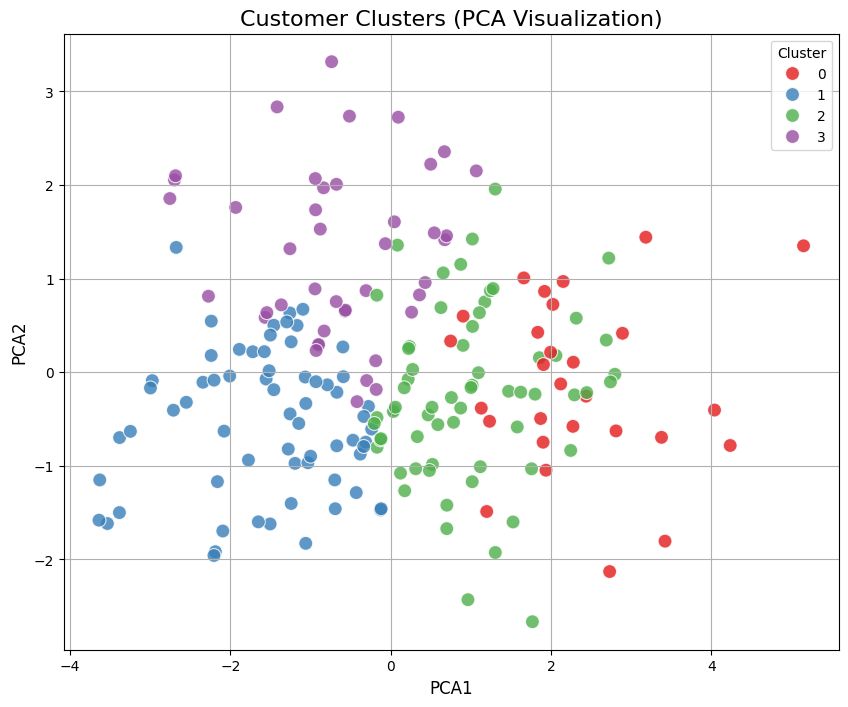

In [3]:
merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left')

# Aggregate transaction data by CustomerID
customer_transactions = (
    merged_df.groupby('CustomerID')
    .agg(
        total_spent=('TotalValue', 'sum'),
        avg_spent=('TotalValue', 'mean'),
        transaction_count=('TransactionID', 'count'),
        unique_products=('ProductID', 'nunique')
    )
    .reset_index()
)

# Add customer profile information
customer_profiles = customers_df[['CustomerID', 'Region']]
clustering_data = customer_transactions.merge(customer_profiles, on='CustomerID', how='left')

# Encode categorical Region feature
label_encoder = LabelEncoder()
clustering_data['Region_Encoded'] = label_encoder.fit_transform(clustering_data['Region'])

# Select features for clustering
features = ['total_spent', 'avg_spent', 'transaction_count', 'unique_products', 'Region_Encoded']


scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

clustering_data['Cluster'] = clusters

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
clustering_data['PCA1'] = pca_result[:, 0]
clustering_data['PCA2'] = pca_result[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', palette='Set1', data=clustering_data, s=100, alpha=0.8
)
plt.title('Customer Clusters (PCA Visualization)', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.grid(True)
plt.show()


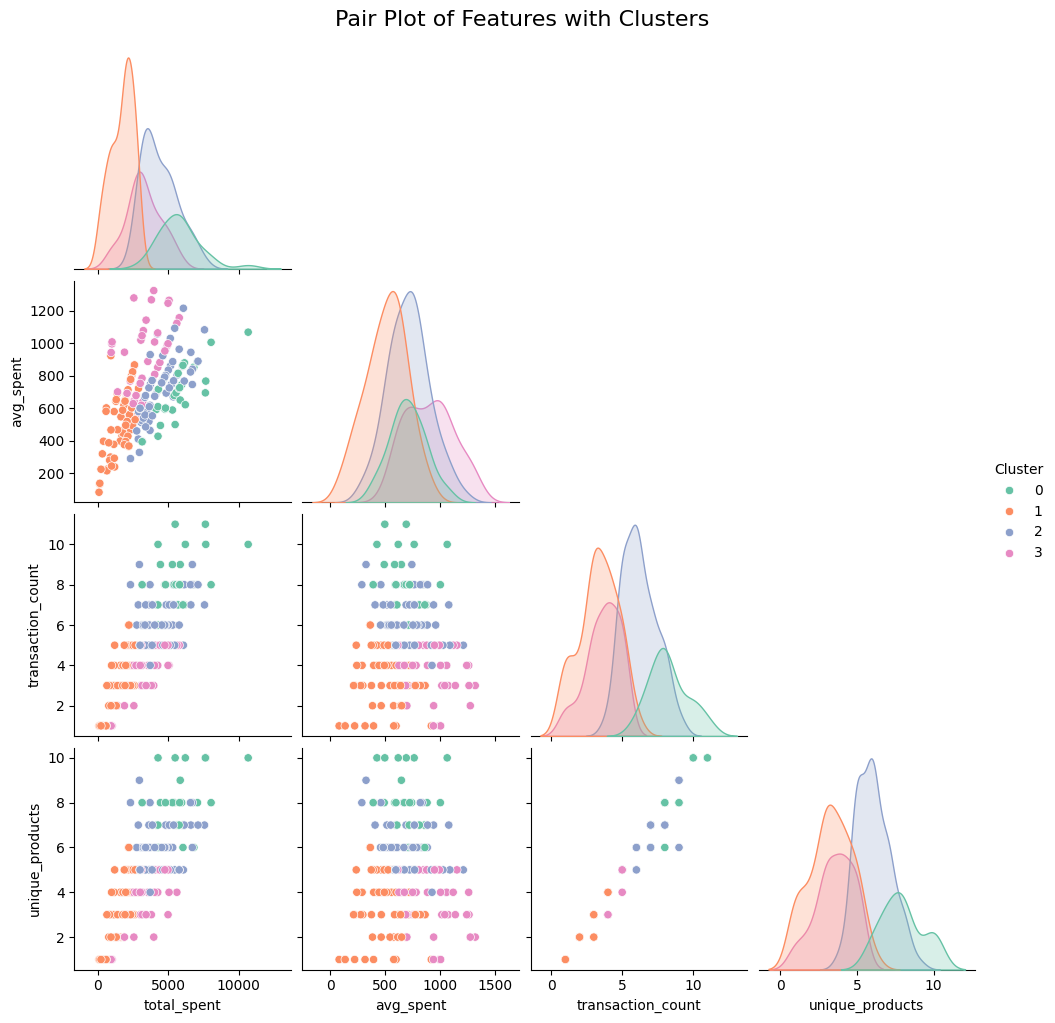

In [4]:

sns.pairplot(
    clustering_data,
    vars=['total_spent', 'avg_spent', 'transaction_count', 'unique_products'],
    hue='Cluster',
    palette='Set2',
    diag_kind='kde',
    corner=True
)
plt.suptitle('Pair Plot of Features with Clusters', y=1.02, fontsize=16)
plt.show()


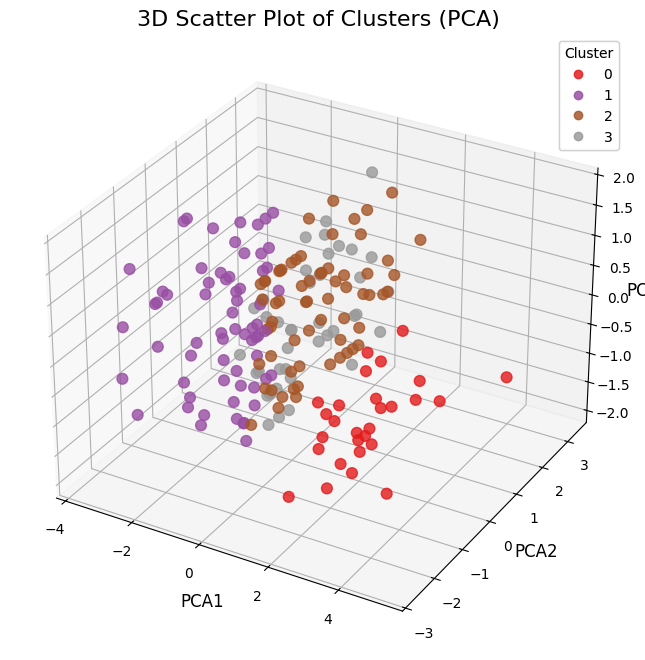

In [5]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(scaled_features)


clustering_data['PCA3D_1'] = pca_result_3d[:, 0]
clustering_data['PCA3D_2'] = pca_result_3d[:, 1]
clustering_data['PCA3D_3'] = pca_result_3d[:, 2]

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    clustering_data['PCA3D_1'], clustering_data['PCA3D_2'], clustering_data['PCA3D_3'],
    c=clustering_data['Cluster'], cmap='Set1', s=60, alpha=0.8
)
ax.set_title('3D Scatter Plot of Clusters (PCA)', fontsize=16)
ax.set_xlabel('PCA1', fontsize=12)
ax.set_ylabel('PCA2', fontsize=12)
ax.set_zlabel('PCA3', fontsize=12)
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", loc="upper right")
ax.add_artist(legend1)
plt.show()


<Figure size 1000x600 with 0 Axes>

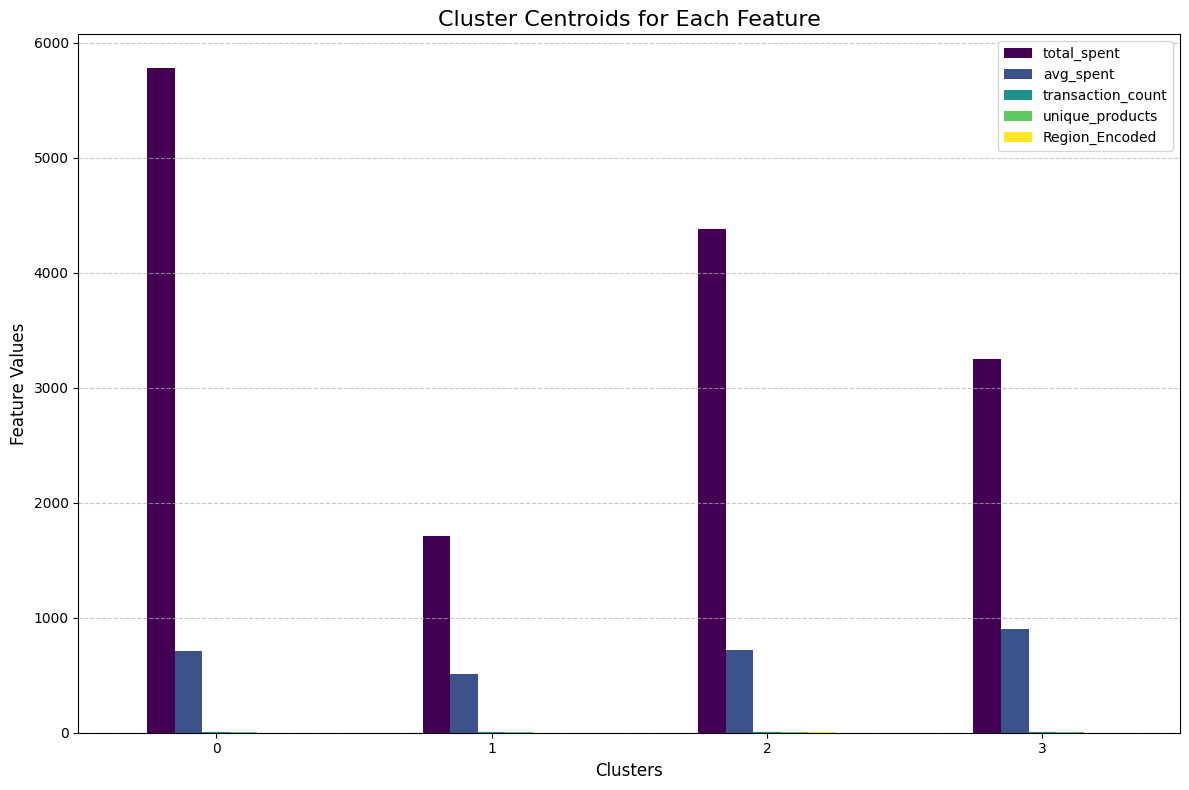

In [6]:

centroids = kmeans.cluster_centers_
centroids_unscaled = scaler.inverse_transform(centroids)

# Plot cluster centroids
centroid_df = pd.DataFrame(centroids_unscaled, columns=features)
centroid_df.index.name = 'Cluster'

plt.figure(figsize=(10, 6))
centroid_df.plot(kind='bar', figsize=(12, 8), colormap='viridis', rot=0)
plt.title('Cluster Centroids for Each Feature', fontsize=16)
plt.ylabel('Feature Values', fontsize=12)
plt.xlabel('Clusters', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
